In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import layers
import numpy as np
import os

## Select base model to apply transfer learning to 
<table style="border: 0px; width: 100%;">
  <th style="border: 0px">
    <tr style="border: 0px; font-weight: bold">
      <td style="border: 0px">Model Name</td>
      <td style="border: 0px">Input Size</td>
      <td style="border: 0px">Data Range</td>
      <td style="border: 0px">Total Params</td>
    </tr>
  </th>
  <tbody>
    <tr style="border: 0px">
      <td style="border: 0px">InceptionResNet2</td>
      <td style="border: 0px">299x299x3</td>
      <td style="border: 0px">-1, 1</td>
      <td style="border: 0px">56M</td>
    </tr>
    <tr style="border: 0px">
      <td style="border: 0px">Xception</td>
      <td style="border: 0px">150x150x3</td>
      <td style="border: 0px">-1, 1</td>
      <td style="border: 0px">23M</td>
    </tr>
  </tbody>
  
</table>

In [5]:
image_shape = (299, 299, 3)
base_model = keras.applications.InceptionResNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=image_shape,
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

### Define random data augmentation function

In [6]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1), layers.RandomZoom(0.1)], 
    name="data_augmentation"
)

In [7]:
# Create new model on top
inputs = keras.Input(shape=image_shape, name="image_input")
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Inception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1, name="rescale")
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(3)(x)  # Number of emotions to be predicted 
model = keras.Model(inputs, outputs, name="AffectNN")
model.summary()

Model: "AffectNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 299, 299, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ data_augmentation (Sequential)  │ (None, 299, 299, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ rescale (Rescaling)             │ (None, 299, 299, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ inception_resnet_v2             │ (None, 8, 8, 1536)        │ 54,336,736 │
│ (Functional)                    │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d_1      │ (None, 1536)              │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 1536)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 3)                 │      4,611 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 54,341,347 (207.30 MB)

 Trainable params: 4,611 (18.01 KB)

 Non-trainable params: 54,336,736 (207.28 MB)

# Import the dataset to train the images

In [9]:
base_path_structured = "/Users/benhoskings/Documents/Datasets/Fusion"
train_path_structured = os.path.join(base_path_structured, "train_set")

class_names = ["Anger", "Disgust", "Happy", "Neutral", "Fear", "Sad", "Surprise"]
batch_size = 128

train_ds = keras.utils.image_dataset_from_directory(
    train_path_structured, 
    class_names=class_names,
    label_mode="categorical", 
    labels="inferred",
    batch_size=batch_size,
    image_size=(299, 299),
    seed=101)

val_ds = keras.utils.image_dataset_from_directory(
    os.path.join(base_path_structured, "val_set"), 
    class_names=class_names,
    label_mode="categorical", 
    labels="inferred",
    batch_size=batch_size,
    image_size=(299, 299),
    seed=101)

ValueError: The `class_names` passed did not match the names of the subdirectories of the target directory. Expected: ['Negative', 'Neutral', 'Positive'] (or a subset of it), but received: class_names=['Anger', 'Disgust', 'Happy', 'Neutral', 'Fear', 'Sad', 'Surprise']

## Display a selectio of the images, with their labels

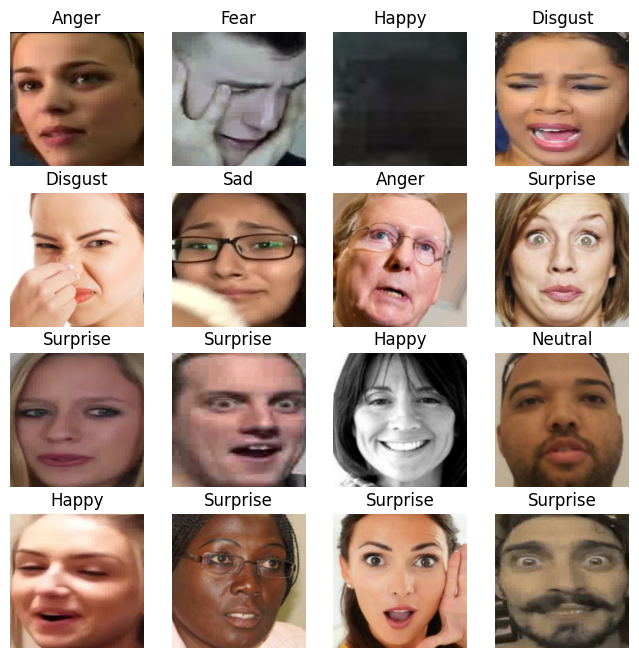

In [6]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

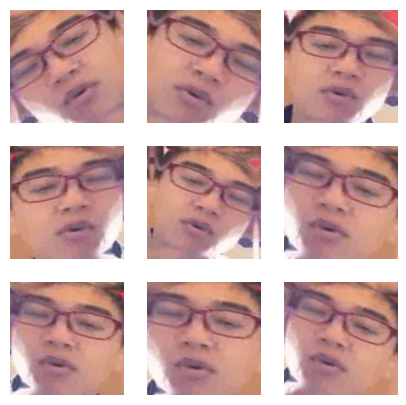

In [7]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1).cache():
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

In [18]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
validation_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [19]:
# SPECIFY LEARNING RATE
base_learning_rate = 0.001

model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=base_learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

total_epochs = 10

In [20]:
checkpoint_filepath = '/Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective_computing/data/checkpoints/checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True, 
    save_freq="epoch")

In [21]:
train_history = model.fit(train_ds, epochs=total_epochs, validation_data=validation_ds,
                          callbacks=[model_checkpoint_callback])

Epoch 1/10
376/376 [==============================] - ETA: 0s - loss: 0.4015 - categorical_accuracy: 0.2713INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2324s 6s/step - loss: 0.4015 - categorical_accuracy: 0.2713 - val_loss: 0.3890 - val_categorical_accuracy: 0.2777
Epoch 2/10
376/376 [==============================] - ETA: 0s - loss: 0.3725 - categorical_accuracy: 0.3528INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2348s 6s/step - loss: 0.3725 - categorical_accuracy: 0.3528 - val_loss: 0.3831 - val_categorical_accuracy: 0.3003
Epoch 3/10
376/376 [==============================] - ETA: 0s - loss: 0.3654 - categorical_accuracy: 0.3717INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2341s 6s/step - loss: 0.3654 - categorical_accuracy: 0.3717 - val_loss: 0.3800 - val_categorical_accuracy: 0.3083
Epoch 4/10
376/376 [==============================] - ETA: 0s - loss: 0.3606 - categorical_accuracy: 0.3846INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2306s 6s/step - loss: 0.3606 - categorical_accuracy: 0.3846 - val_loss: 0.3787 - val_categorical_accuracy: 0.3123
Epoch 5/10
376/376 [==============================] - ETA: 0s - loss: 0.3584 - categorical_accuracy: 0.3900INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2296s 6s/step - loss: 0.3584 - categorical_accuracy: 0.3900 - val_loss: 0.3780 - val_categorical_accuracy: 0.3146
Epoch 6/10
376/376 [==============================] - ETA: 0s - loss: 0.3566 - categorical_accuracy: 0.3951INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2305s 6s/step - loss: 0.3566 - categorical_accuracy: 0.3951 - val_loss: 0.3761 - val_categorical_accuracy: 0.3206
Epoch 7/10
376/376 [==============================] - 2255s 6s/step - loss: 0.3548 - categorical_accuracy: 0.3971 - val_loss: 0.3760 - val_categorical_accuracy: 0.3186
Epoch 8/10
376/376 [==============================] - ETA: 0s - loss: 0.3554 - categorical_accuracy: 0.3965INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2310s 6s/step - loss: 0.3554 - categorical_accuracy: 0.3965 - val_loss: 0.3751 - val_categorical_accuracy: 0.3264
Epoch 9/10
376/376 [==============================] - ETA: 0s - loss: 0.3535 - categorical_accuracy: 0.4015INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2335s 6s/step - loss: 0.3535 - categorical_accuracy: 0.4015 - val_loss: 0.3735 - val_categorical_accuracy: 0.3278
Epoch 10/10
376/376 [==============================] - 2278s 6s/step - loss: 0.3532 - categorical_accuracy: 0.4025 - val_loss: 0.3748 - val_categorical_accuracy: 0.3232


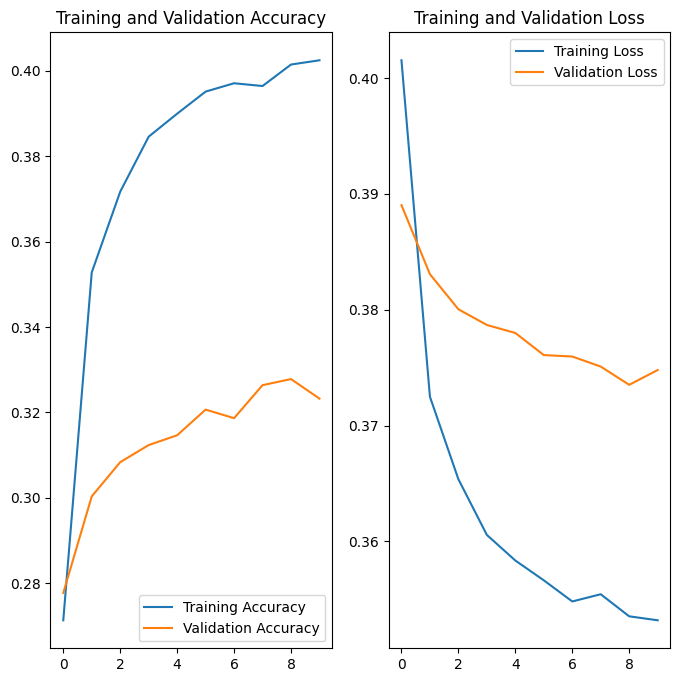

In [22]:
acc = train_history.history['categorical_accuracy']
val_acc = train_history.history['val_categorical_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

epochs_range = range(total_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
def edit_trainable_layers(count,  mod):
    mod.trainable = True
    for layer in base_model.layers[:len(mod.layers) - count]:
      layer.trainable = False
        
    print("Number of trainable variables in the base model: ", len(mod.trainable_variables))

In [24]:
base_rate = 0.001
layer_counts = [10, 20, 30, 40, 50, 60]
rates = [base_rate / min([l_count*10, 200]) for l_count in layer_counts]
epochs = [10 for _ in layer_counts]

    
for l_count, epoch, rate in zip(layer_counts, epochs, rates):
    edit_trainable_layers(l_count, base_model)
        
    model.compile(
        optimizer=keras.optimizers.legacy.Adam(learning_rate=rate),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.CategoricalAccuracy()],
    )
    
    total_epochs += epoch
    
    train_history = model.fit(train_ds,
                             epochs=total_epochs,
                             initial_epoch=train_history.epoch[-1],
                             validation_data=val_ds,
                             callbacks=[model_checkpoint_callback])
    
    acc += train_history.history['categorical_accuracy']
    val_acc += train_history.history['val_categorical_accuracy']
    
    loss += train_history.history['loss']
    val_loss += train_history.history['val_loss']

Number of trainable variables in the base model:  6
Epoch 10/20
376/376 [==============================] - ETA: 0s - loss: 0.3465 - categorical_accuracy: 0.4196INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2533s 7s/step - loss: 0.3465 - categorical_accuracy: 0.4196 - val_loss: 0.3688 - val_categorical_accuracy: 0.3410
Epoch 11/20
376/376 [==============================] - ETA: 0s - loss: 0.3383 - categorical_accuracy: 0.4395INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2499s 7s/step - loss: 0.3383 - categorical_accuracy: 0.4395 - val_loss: 0.3647 - val_categorical_accuracy: 0.3496
Epoch 12/20
376/376 [==============================] - ETA: 0s - loss: 0.3325 - categorical_accuracy: 0.4517INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2485s 7s/step - loss: 0.3325 - categorical_accuracy: 0.4517 - val_loss: 0.3614 - val_categorical_accuracy: 0.3573
Epoch 13/20
376/376 [==============================] - ETA: 0s - loss: 0.3273 - categorical_accuracy: 0.4624INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2487s 7s/step - loss: 0.3273 - categorical_accuracy: 0.4624 - val_loss: 0.3590 - val_categorical_accuracy: 0.3599
Epoch 14/20
376/376 [==============================] - ETA: 0s - loss: 0.3224 - categorical_accuracy: 0.4729INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2492s 7s/step - loss: 0.3224 - categorical_accuracy: 0.4729 - val_loss: 0.3567 - val_categorical_accuracy: 0.3679
Epoch 15/20
376/376 [==============================] - ETA: 0s - loss: 0.3190 - categorical_accuracy: 0.4795INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2487s 7s/step - loss: 0.3190 - categorical_accuracy: 0.4795 - val_loss: 0.3545 - val_categorical_accuracy: 0.3719
Epoch 16/20
376/376 [==============================] - ETA: 0s - loss: 0.3158 - categorical_accuracy: 0.4859INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2485s 7s/step - loss: 0.3158 - categorical_accuracy: 0.4859 - val_loss: 0.3524 - val_categorical_accuracy: 0.3793
Epoch 17/20
376/376 [==============================] - ETA: 0s - loss: 0.3124 - categorical_accuracy: 0.4939INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2484s 7s/step - loss: 0.3124 - categorical_accuracy: 0.4939 - val_loss: 0.3504 - val_categorical_accuracy: 0.3876
Epoch 18/20
376/376 [==============================] - ETA: 0s - loss: 0.3093 - categorical_accuracy: 0.5013INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2489s 7s/step - loss: 0.3093 - categorical_accuracy: 0.5013 - val_loss: 0.3485 - val_categorical_accuracy: 0.3931
Epoch 19/20
376/376 [==============================] - ETA: 0s - loss: 0.3066 - categorical_accuracy: 0.5065INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2454s 7s/step - loss: 0.3066 - categorical_accuracy: 0.5065 - val_loss: 0.3471 - val_categorical_accuracy: 0.3968
Epoch 20/20
376/376 [==============================] - ETA: 0s - loss: 0.3044 - categorical_accuracy: 0.5107INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2433s 6s/step - loss: 0.3044 - categorical_accuracy: 0.5107 - val_loss: 0.3453 - val_categorical_accuracy: 0.4028
Number of trainable variables in the base model:  12
Epoch 20/30
376/376 [==============================] - ETA: 0s - loss: 0.3016 - categorical_accuracy: 0.5180INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2457s 7s/step - loss: 0.3016 - categorical_accuracy: 0.5180 - val_loss: 0.3445 - val_categorical_accuracy: 0.4037
Epoch 21/30
376/376 [==============================] - ETA: 0s - loss: 0.2998 - categorical_accuracy: 0.5183INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2452s 7s/step - loss: 0.2998 - categorical_accuracy: 0.5183 - val_loss: 0.3429 - val_categorical_accuracy: 0.4065
Epoch 22/30
376/376 [==============================] - ETA: 0s - loss: 0.2973 - categorical_accuracy: 0.5257INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2459s 7s/step - loss: 0.2973 - categorical_accuracy: 0.5257 - val_loss: 0.3420 - val_categorical_accuracy: 0.4088
Epoch 23/30
376/376 [==============================] - ETA: 0s - loss: 0.2953 - categorical_accuracy: 0.5301INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2464s 7s/step - loss: 0.2953 - categorical_accuracy: 0.5301 - val_loss: 0.3410 - val_categorical_accuracy: 0.4111
Epoch 24/30
376/376 [==============================] - ETA: 0s - loss: 0.2943 - categorical_accuracy: 0.5290INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2464s 7s/step - loss: 0.2943 - categorical_accuracy: 0.5290 - val_loss: 0.3395 - val_categorical_accuracy: 0.4125
Epoch 25/30
376/376 [==============================] - ETA: 0s - loss: 0.2920 - categorical_accuracy: 0.5360INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2455s 7s/step - loss: 0.2920 - categorical_accuracy: 0.5360 - val_loss: 0.3386 - val_categorical_accuracy: 0.4194
Epoch 26/30
376/376 [==============================] - ETA: 0s - loss: 0.2904 - categorical_accuracy: 0.5379INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2455s 7s/step - loss: 0.2904 - categorical_accuracy: 0.5379 - val_loss: 0.3378 - val_categorical_accuracy: 0.4203
Epoch 27/30
376/376 [==============================] - ETA: 0s - loss: 0.2882 - categorical_accuracy: 0.5429INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2454s 7s/step - loss: 0.2882 - categorical_accuracy: 0.5429 - val_loss: 0.3367 - val_categorical_accuracy: 0.4263
Epoch 28/30
376/376 [==============================] - 2412s 6s/step - loss: 0.2872 - categorical_accuracy: 0.5468 - val_loss: 0.3361 - val_categorical_accuracy: 0.4223
Epoch 29/30
376/376 [==============================] - 2421s 6s/step - loss: 0.2852 - categorical_accuracy: 0.5487 - val_loss: 0.3361 - val_categorical_accuracy: 0.4246
Epoch 30/30
376/376 [==============================] - 2416s 6s/step - loss: 0.2830 - categorical_accuracy: 0.5541 - val_loss: 0.3342 - val_categorical_accuracy: 0.4257
Number of trainable variables in the base model:  19
Epoch 30/40
376/376 [==============================] - ETA: 0s - loss: 0.2810 - categorical_accuracy: 0.5565INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2536s 7s/step - loss: 0.2810 - categorical_accuracy: 0.5565 - val_loss: 0.3325 - val_categorical_accuracy: 0.4314
Epoch 31/40
376/376 [==============================] - ETA: 0s - loss: 0.2786 - categorical_accuracy: 0.5612INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2528s 7s/step - loss: 0.2786 - categorical_accuracy: 0.5612 - val_loss: 0.3314 - val_categorical_accuracy: 0.4400
Epoch 32/40
376/376 [==============================] - ETA: 0s - loss: 0.2764 - categorical_accuracy: 0.5656INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2510s 7s/step - loss: 0.2764 - categorical_accuracy: 0.5656 - val_loss: 0.3306 - val_categorical_accuracy: 0.4412
Epoch 33/40
376/376 [==============================] - ETA: 0s - loss: 0.2734 - categorical_accuracy: 0.5717INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2519s 7s/step - loss: 0.2734 - categorical_accuracy: 0.5717 - val_loss: 0.3297 - val_categorical_accuracy: 0.4443
Epoch 34/40
376/376 [==============================] - ETA: 0s - loss: 0.2724 - categorical_accuracy: 0.5750INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2516s 7s/step - loss: 0.2724 - categorical_accuracy: 0.5750 - val_loss: 0.3279 - val_categorical_accuracy: 0.4457
Epoch 35/40
376/376 [==============================] - ETA: 0s - loss: 0.2705 - categorical_accuracy: 0.5796INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2520s 7s/step - loss: 0.2705 - categorical_accuracy: 0.5796 - val_loss: 0.3266 - val_categorical_accuracy: 0.4529
Epoch 36/40
376/376 [==============================] - 2471s 7s/step - loss: 0.2687 - categorical_accuracy: 0.5820 - val_loss: 0.3256 - val_categorical_accuracy: 0.4529
Epoch 37/40
376/376 [==============================] - 2467s 7s/step - loss: 0.2666 - categorical_accuracy: 0.5849 - val_loss: 0.3256 - val_categorical_accuracy: 0.4512
Epoch 38/40
376/376 [==============================] - ETA: 0s - loss: 0.2646 - categorical_accuracy: 0.5869INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2516s 7s/step - loss: 0.2646 - categorical_accuracy: 0.5869 - val_loss: 0.3237 - val_categorical_accuracy: 0.4575
Epoch 39/40
376/376 [==============================] - 2468s 7s/step - loss: 0.2637 - categorical_accuracy: 0.5904 - val_loss: 0.3240 - val_categorical_accuracy: 0.4552
Epoch 40/40
376/376 [==============================] - ETA: 0s - loss: 0.2619 - categorical_accuracy: 0.5930INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2515s 7s/step - loss: 0.2619 - categorical_accuracy: 0.5930 - val_loss: 0.3233 - val_categorical_accuracy: 0.4595
Number of trainable variables in the base model:  24
Epoch 40/50
376/376 [==============================] - ETA: 0s - loss: 0.2598 - categorical_accuracy: 0.5995INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2552s 7s/step - loss: 0.2598 - categorical_accuracy: 0.5995 - val_loss: 0.3221 - val_categorical_accuracy: 0.4618
Epoch 41/50
376/376 [==============================] - ETA: 0s - loss: 0.2582 - categorical_accuracy: 0.6006INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2557s 7s/step - loss: 0.2582 - categorical_accuracy: 0.6006 - val_loss: 0.3217 - val_categorical_accuracy: 0.4664
Epoch 42/50
376/376 [==============================] - 2510s 7s/step - loss: 0.2557 - categorical_accuracy: 0.6066 - val_loss: 0.3219 - val_categorical_accuracy: 0.4652
Epoch 43/50
376/376 [==============================] - ETA: 0s - loss: 0.2541 - categorical_accuracy: 0.6074INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2547s 7s/step - loss: 0.2541 - categorical_accuracy: 0.6074 - val_loss: 0.3205 - val_categorical_accuracy: 0.4701
Epoch 44/50
376/376 [==============================] - 2501s 7s/step - loss: 0.2528 - categorical_accuracy: 0.6111 - val_loss: 0.3196 - val_categorical_accuracy: 0.4681
Epoch 45/50
376/376 [==============================] - ETA: 0s - loss: 0.2510 - categorical_accuracy: 0.6143INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2549s 7s/step - loss: 0.2510 - categorical_accuracy: 0.6143 - val_loss: 0.3186 - val_categorical_accuracy: 0.4715
Epoch 46/50
376/376 [==============================] - ETA: 0s - loss: 0.2495 - categorical_accuracy: 0.6171INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2548s 7s/step - loss: 0.2495 - categorical_accuracy: 0.6171 - val_loss: 0.3172 - val_categorical_accuracy: 0.4758
Epoch 47/50
376/376 [==============================] - 2502s 7s/step - loss: 0.2479 - categorical_accuracy: 0.6206 - val_loss: 0.3174 - val_categorical_accuracy: 0.4724
Epoch 48/50
376/376 [==============================] - ETA: 0s - loss: 0.2462 - categorical_accuracy: 0.6238INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2550s 7s/step - loss: 0.2462 - categorical_accuracy: 0.6238 - val_loss: 0.3177 - val_categorical_accuracy: 0.4770
Epoch 49/50
376/376 [==============================] - ETA: 0s - loss: 0.2446 - categorical_accuracy: 0.6262INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2559s 7s/step - loss: 0.2446 - categorical_accuracy: 0.6262 - val_loss: 0.3160 - val_categorical_accuracy: 0.4781
Epoch 50/50
376/376 [==============================] - ETA: 0s - loss: 0.2423 - categorical_accuracy: 0.6307INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2553s 7s/step - loss: 0.2423 - categorical_accuracy: 0.6307 - val_loss: 0.3152 - val_categorical_accuracy: 0.4833
Number of trainable variables in the base model:  32
Epoch 50/60
376/376 [==============================] - 2545s 7s/step - loss: 0.2409 - categorical_accuracy: 0.6342 - val_loss: 0.3156 - val_categorical_accuracy: 0.4824
Epoch 51/60
376/376 [==============================] - ETA: 0s - loss: 0.2389 - categorical_accuracy: 0.6370INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2589s 7s/step - loss: 0.2389 - categorical_accuracy: 0.6370 - val_loss: 0.3144 - val_categorical_accuracy: 0.4867
Epoch 52/60
376/376 [==============================] - 2537s 7s/step - loss: 0.2371 - categorical_accuracy: 0.6413 - val_loss: 0.3154 - val_categorical_accuracy: 0.4841
Epoch 53/60
376/376 [==============================] - 2537s 7s/step - loss: 0.2358 - categorical_accuracy: 0.6431 - val_loss: 0.3134 - val_categorical_accuracy: 0.4858
Epoch 54/60
376/376 [==============================] - ETA: 0s - loss: 0.2342 - categorical_accuracy: 0.6471INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2587s 7s/step - loss: 0.2342 - categorical_accuracy: 0.6471 - val_loss: 0.3142 - val_categorical_accuracy: 0.4878
Epoch 55/60
376/376 [==============================] - ETA: 0s - loss: 0.2332 - categorical_accuracy: 0.6478INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2592s 7s/step - loss: 0.2332 - categorical_accuracy: 0.6478 - val_loss: 0.3127 - val_categorical_accuracy: 0.4881
Epoch 56/60
376/376 [==============================] - ETA: 0s - loss: 0.2316 - categorical_accuracy: 0.6509INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2594s 7s/step - loss: 0.2316 - categorical_accuracy: 0.6509 - val_loss: 0.3130 - val_categorical_accuracy: 0.4896
Epoch 57/60
376/376 [==============================] - ETA: 0s - loss: 0.2303 - categorical_accuracy: 0.6524INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2585s 7s/step - loss: 0.2303 - categorical_accuracy: 0.6524 - val_loss: 0.3120 - val_categorical_accuracy: 0.4947
Epoch 58/60
376/376 [==============================] - 2538s 7s/step - loss: 0.2284 - categorical_accuracy: 0.6572 - val_loss: 0.3124 - val_categorical_accuracy: 0.4916
Epoch 59/60
376/376 [==============================] - ETA: 0s - loss: 0.2274 - categorical_accuracy: 0.6616INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2587s 7s/step - loss: 0.2274 - categorical_accuracy: 0.6616 - val_loss: 0.3112 - val_categorical_accuracy: 0.4973
Epoch 60/60
376/376 [==============================] - 2537s 7s/step - loss: 0.2251 - categorical_accuracy: 0.6632 - val_loss: 0.3117 - val_categorical_accuracy: 0.4938
Number of trainable variables in the base model:  38
Epoch 60/70
376/376 [==============================] - ETA: 0s - loss: 0.2251 - categorical_accuracy: 0.6634INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2639s 7s/step - loss: 0.2251 - categorical_accuracy: 0.6634 - val_loss: 0.3103 - val_categorical_accuracy: 0.5030
Epoch 61/70
376/376 [==============================] - 2589s 7s/step - loss: 0.2235 - categorical_accuracy: 0.6657 - val_loss: 0.3106 - val_categorical_accuracy: 0.5001
Epoch 62/70
376/376 [==============================] - 2596s 7s/step - loss: 0.2213 - categorical_accuracy: 0.6711 - val_loss: 0.3108 - val_categorical_accuracy: 0.5004
Epoch 63/70
376/376 [==============================] - 2583s 7s/step - loss: 0.2195 - categorical_accuracy: 0.6734 - val_loss: 0.3104 - val_categorical_accuracy: 0.5004
Epoch 64/70
376/376 [==============================] - 2581s 7s/step - loss: 0.2191 - categorical_accuracy: 0.6745 - val_loss: 0.3096 - val_categorical_accuracy: 0.5027
Epoch 65/70
376/376 [==============================] - ETA: 0s - loss: 0.2170 - categorical_accuracy: 0.6773INFO:tensorflow:Assets written to: /Users/benhoskings/Docum

INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2628s 7s/step - loss: 0.2170 - categorical_accuracy: 0.6773 - val_loss: 0.3098 - val_categorical_accuracy: 0.5079
Epoch 66/70
376/376 [==============================] - 2577s 7s/step - loss: 0.2156 - categorical_accuracy: 0.6812 - val_loss: 0.3092 - val_categorical_accuracy: 0.5070
Epoch 67/70
376/376 [==============================] - 2580s 7s/step - loss: 0.2145 - categorical_accuracy: 0.6828 - val_loss: 0.3094 - val_categorical_accuracy: 0.5070
Epoch 68/70
376/376 [==============================] - ETA: 0s - loss: 0.2130 - categorical_accuracy: 0.6861INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2632s 7s/step - loss: 0.2130 - categorical_accuracy: 0.6861 - val_loss: 0.3080 - val_categorical_accuracy: 0.5087
Epoch 69/70
376/376 [==============================] - ETA: 0s - loss: 0.2124 - categorical_accuracy: 0.6862INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


INFO:tensorflow:Assets written to: /Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint/assets


376/376 [==============================] - 2638s 7s/step - loss: 0.2124 - categorical_accuracy: 0.6862 - val_loss: 0.3088 - val_categorical_accuracy: 0.5096
Epoch 70/70
376/376 [==============================] - 2581s 7s/step - loss: 0.2100 - categorical_accuracy: 0.6919 - val_loss: 0.3087 - val_categorical_accuracy: 0.5076


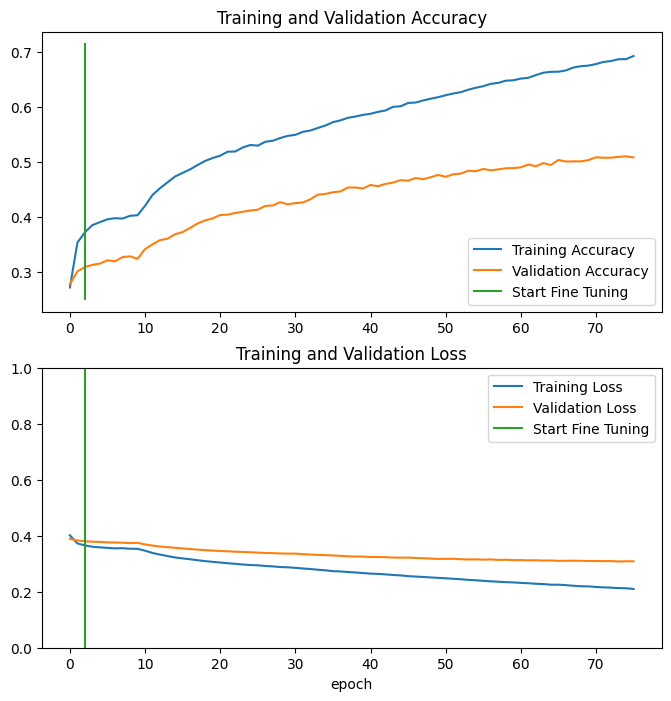

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([2,2], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([2,2], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
img = keras.utils.load_img("sample_images/Fear.png", target_size=(299, 299))

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 134ms/step
This image most likely belongs to Sad with a 62.97 percent confidence.


In [27]:
model.save("data/AffectInceptionResNetV2.keras")